In [1]:
import csv
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
import h5py
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Lambda, Conv2D, MaxPooling2D, Cropping2D, Dropout

%matplotlib inline

Using TensorFlow backend.


In [2]:
lines = []
image_base_dir = ''
with open('c:/dl/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [3]:
def read_rgb_image(image_file):
    img = cv.imread(image_file)
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

# 1. Nvidia model 1
#### Image - Left lane, right lane and middle lane. Loss = mse, optimizer= adam, activation function = tanh, 

Train on 49948 samples, validate on 12488 samples
Epoch 1/10
49948/49948 [==============================] - 315s 6ms/step - loss: 0.0747 - val_loss: 0.0439
Epoch 2/10
49948/49948 [==============================] - 300s 6ms/step - loss: 0.0370 - val_loss: 0.0528
Epoch 3/10
49948/49948 [==============================] - 300s 6ms/step - loss: 0.0340 - val_loss: 0.0442
Epoch 4/10
49948/49948 [==============================] - 301s 6ms/step - loss: 0.0321 - val_loss: 0.0487
Epoch 5/10
49948/49948 [==============================] - 304s 6ms/step - loss: 0.0334 - val_loss: 0.0415
Epoch 6/10
49948/49948 [==============================] - 301s 6ms/step - loss: 0.0326 - val_loss: 0.0505
Epoch 7/10
49948/49948 [==============================] - 301s 6ms/step - loss: 0.0324 - val_loss: 0.0400
Epoch 8/10
49948/49948 [==============================] - 301s 6ms/step - loss: 0.0306 - val_loss: 0.0407
Epoch 9/10
49948/49948 [==============================] - 302s 6ms/step - loss: 0.0279 - val_loss: 0.0395
Epoch 10/10
49948/49948 [==============================] - 302s 6ms/step - loss: 0.0262 - val_loss: 0.0403

In [4]:
def image_selection_training_data_1(left_img_f, center_img_f, right_img_f, steering):
    ## Here we are just considering the middle image.
    yield read_rgb_image(image_base_dir + center_img_f), steering
    

In [5]:
def image_selection_left_righ_center(left_img_f, center_img_f, right_img_f, steering):
    random = np.random.choice(71)
    if (random % 5) == 0 :
        yield read_rgb_image(image_base_dir + center_img_f), steering
        yield read_rgb_image(image_base_dir + left_img_f), steering + 0.20
        yield read_rgb_image(image_base_dir + right_img_f), steering - 0.20
    elif (random % 3) == 0:
        yield read_rgb_image(image_base_dir + center_img_f), steering
    elif (random % 3) == 1:
        yield read_rgb_image(image_base_dir + left_img_f), steering + 0.20
    else:
        yield read_rgb_image(image_base_dir + right_img_f), steering - 0.20

In [6]:
def image_selection_random_from_left_right(left_img_f, center_img_f, right_img_f, steering):
    random = np.random.choice(2)
    
    yield read_rgb_image(image_base_dir + center_img_f), steering
    if (random % 2) == 0:
        yield read_rgb_image(image_base_dir + left_img_f), steering + 0.20
    else:
        yield read_rgb_image(image_base_dir + right_img_f), steering - 0.20

In [7]:
center_images = []
steering = []
header=True
for line in lines:
    if header:
        header = False
        continue
    #print (line)
    str_ang = float(line[3])
    for (img, ang) in image_selection_random_from_left_right(line[1], line[0], line[2], str_ang):
        center_images.append(img)
        steering.append(ang)
#     correction = 0.2
#     image_file = line[0]
#     steering_center = float(line[3])
#     if (steering_center > -0.00001 and steering_center < 0.00001):
#         choice = np.random.choice(3)
#         if choice != 0:
#             continue
#     center_image = read_rgb_image(line[0])
#     left_image = read_rgb_image(line[1])
#     right_image = read_rgb_image(line[2])
#     center_images.append(center_image)
#     center_images.append(left_image)
#     center_images.append(right_image)
#     steering.append(steering_center)
#     steering.append(steering_center + correction)
#     steering.append(steering_center - correction)

In [8]:
original_training_image = len(center_images)

In [9]:
#augmenting the training data by fliping images and their measurement
for i in range(original_training_image):
    center_images.append(np.fliplr(center_images[i]))
    steering.append(-steering[i])

In [10]:
center_images = np.array(center_images)
steering = np.array(steering)

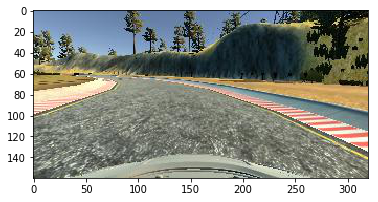

In [11]:
plt.imshow(center_images[0])

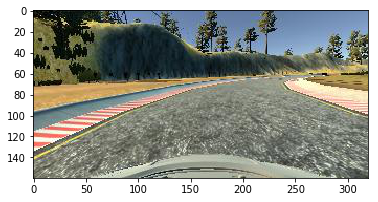

In [12]:
plt.imshow(np.fliplr(center_images[0]))

In [13]:
center_images[0].shape

(160, 320, 3)

In [14]:
len(center_images)

74056

In [15]:
def convert_RGB_to_GRAY(image):
    rgb_img = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    #rg_img = cv.normalize(rgb_img, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    return rgb_img[:,:, np.newaxis]

In [16]:
def preprocess_image(x):
    gray_image = lambda t : convert_RGB_to_GRAY(t)
    
    x = np.array(list(map(gray_image, x)))
    x = x.astype(float)/128.0
    return x

In [17]:
#center_images = preprocess_image(center_images)

In [18]:
def Lent_model(in_shape, dropout):
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=in_shape))
    model.add(Cropping2D(cropping=((50,20),(0,0))))
    model.add(Conv2D(6,(5,5), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16, (5,5), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))
    
    return model

In [19]:
def Nvidia_model(in_shape, dropout):
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=in_shape))
    model.add(Cropping2D(cropping=((50,20),(0,0))))

    model.add(Conv2D(24, (5, 5), padding='valid', activation = 'tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(36, (5, 5), padding='valid', activation = 'tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(48, (5, 5), padding='valid', activation = 'tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64,(3, 3), padding='valid', activation = 'tanh'))

    model.add(Conv2D(64,(3,3), padding='valid', activation = 'tanh'))

    model.add(Flatten())
    
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    
    model.summary();
    
    return model

In [20]:
#center_images, steering = shuffle(center_images, steering)

In [21]:
model = Nvidia_model(center_images[0].shape, dropout=0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 316, 24)       1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 154, 36)       21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 77, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 73, 48)        43248     
__________

In [22]:
model.compile(optimizer='adam', loss='mse')

In [23]:
train_history = model.fit(center_images, steering, validation_split=0.10, batch_size=64, shuffle=True, epochs=10)

Train on 66650 samples, validate on 7406 samples
Epoch 1/10
66650/66650 [==============================] - 364s 5ms/step - loss: 0.0642 - val_loss: 0.0373
Epoch 2/10
66650/66650 [==============================] - 334s 5ms/step - loss: 0.0398 - val_loss: 0.0328
Epoch 3/10
66650/66650 [==============================] - 341s 5ms/step - loss: 0.0365 - val_loss: 0.0294
Epoch 4/10
66650/66650 [==============================] - 340s 5ms/step - loss: 0.0352 - val_loss: 0.0306
Epoch 5/10
66650/66650 [==============================] - 337s 5ms/step - loss: 0.0335 - val_loss: 0.0313
Epoch 6/10
66650/66650 [==============================] - 338s 5ms/step - loss: 0.0317 - val_loss: 0.0343
Epoch 7/10
66650/66650 [==============================] - 341s 5ms/step - loss: 0.0303 - val_loss: 0.0311
Epoch 8/10
66650/66650 [==============================] - 338s 5ms/step - loss: 0.0294 - val_loss: 0.0342
Epoch 9/10
66650/66650 [==============================] - 337s 5ms/step - loss: 0.0277 - val_loss: 0.03

In [29]:
train_history.history

{'loss': [0.064167943701248648,
  0.039811038140484201,
  0.036542871396119489,
  0.035239967735790259,
  0.033470023344511927,
  0.031689173817433365,
  0.030337950623826881,
  0.029376476813451471,
  0.027696502749980704,
  0.026566363533054718],
 'val_loss': [0.037313645615541964,
  0.032791603738635725,
  0.029446184648743618,
  0.030558293621183296,
  0.031288862922295518,
  0.0342648786250195,
  0.031147134431962015,
  0.034151583729910909,
  0.035691327446090299,
  0.03958500190676989]}

In [30]:
model.save('model_Nvidia_adam_mse_sampled_straightlane_udacity.h5')

In [31]:
model.predict(center_images[:2])

array([[ 0.02068888],
       [-0.21565449]], dtype=float32)

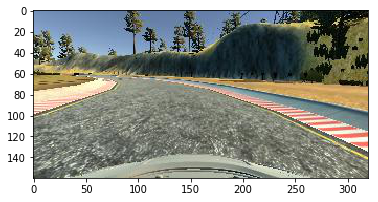

In [32]:
plt.imshow(center_images[0])

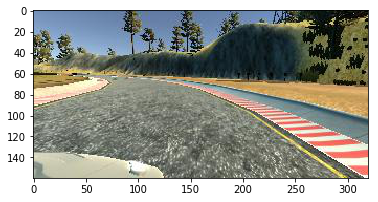

In [33]:
plt.imshow(center_images[1])